In [1]:
# Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import json
import re
import fa2
import math
import community
import matplotlib.cm as cm
from __future__ import division
import matplotlib.image as mpimg
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import io
from collections import Counter
from wordcloud import WordCloud
# Rendering Parameters
title_font = {'family': 'sans-serif',
        'color':  '#000000',
        'weight': 'normal',
        'size': 16,
        }

In [2]:
#Loading
dict_to_compare = {}
newfile = io.open("Data_Set_S1.txt", mode="r", encoding="utf-8")
count = 0
for row in newfile:
    if count < 4:
        count +=1
        continue
        
    string = row.split("\t")
    dict_to_compare[string[0]] = float(string[2])

def happiness(dict_of_tokens,dict_to_compare):
    #dict_of_tokens is the tokenized dictionary with their count (token: count)
    #dict_to_compare is a dictionary that contains word as key and the averaged_happiness_weight as value
    #Return 0 if no tokens
    if len(dict_of_tokens)==0:
        return 0
    #Sum of token frequency multiplied with the averaged_happiness_weight as in (1) from the paper[Dodds, 2011]
    keys = [key for key in dict_of_tokens if key in dict_to_compare.keys()]
    #Normalization can only be calculated after keys since "for which we have an estimate of average happiness"[Dodds, 2011] applies
    normalization = sum(dict_of_tokens[key] for key in keys)
    #Return 0 if no word is present in dict_to_compare
    if normalization==0:
        return 0
    sums = sum(dict_to_compare[key]*dict_of_tokens[key] for key in keys)
    return sums/normalization

In [3]:
moviereviews = {}
moviesentement = {}
for filename in os.listdir("aclImdb/test"):
    if filename.endswith(".txt"):
        text = re.findall("urls_(\w*).txt",filename)
        with open("aclImdb/test/"+filename) as file:
            for idx,line in enumerate(file):
                ID = re.findall("http://www.imdb.com/title/(\w*)/usercomments",line)
                moviereviews[(idx,"test/"+text[0])] = ID[0]
                moviesentement[ID[0]] = [0,0]
for filename in os.listdir("aclImdb/train"):
    if filename.endswith(".txt"):
        text = re.findall("urls_(\w*).txt",filename)
        with open("aclImdb/train/"+filename) as file:
            text = re.findall("urls_(\w*).txt",filename)
            for idx,line in enumerate(file):
                ID = re.findall("http://www.imdb.com/title/(\w*)/usercomments",line)
                moviereviews[(idx,"train/"+text[0])] = ID[0]
                moviesentement[ID[0]] = [0,0]

In [4]:
stopwordslist = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
paths = ["train/unsup","train/pos","train/neg","test/neg","test/pos"]
scores = []
for path in paths:
    done = len(os.listdir("aclImdb/"+path))
    for idx,filename in enumerate(os.listdir("aclImdb/"+path)):
        file = io.open("aclImdb/"+path+"/"+filename, mode="r", encoding="utf-8")
        string = file.readlines()[0]
        w = re.findall(r'@\w*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[\/\w+]*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall("<[^>]*>",string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        string = re.sub(r'\d+', '', string)
        string = string.lower()
        filtered = tokenizer.tokenize(string)
        filtered = [w for w in filtered if w not in stopwordslist]
        review = Counter(filtered)
        score = happiness(review,dict_to_compare)
        moviesentement[moviereviews[(idx,path)]][0] += 1
        moviesentement[moviereviews[(idx,path)]][1] += score
        scores.append(score)
        if idx/done*100%10==0:
            print("Done with {0}% in the corresponding folder {1}.".format(idx/done*100,path))

Done with 0.0% in the corresponding folder train/unsup.
Done with 10.0% in the corresponding folder train/unsup.
Done with 20.0% in the corresponding folder train/unsup.
Done with 30.0% in the corresponding folder train/unsup.
Done with 40.0% in the corresponding folder train/unsup.
Done with 50.0% in the corresponding folder train/unsup.
Done with 60.0% in the corresponding folder train/unsup.
Done with 70.0% in the corresponding folder train/unsup.
Done with 80.0% in the corresponding folder train/unsup.
Done with 90.0% in the corresponding folder train/unsup.
Done with 0.0% in the corresponding folder train/pos.
Done with 10.0% in the corresponding folder train/pos.
Done with 20.0% in the corresponding folder train/pos.
Done with 30.0% in the corresponding folder train/pos.
Done with 40.0% in the corresponding folder train/pos.
Done with 50.0% in the corresponding folder train/pos.
Done with 60.0% in the corresponding folder train/pos.
Done with 70.0% in the corresponding folder tra

In [5]:
with open('sentiment.txt', 'w') as file:
     file.write(json.dumps(moviesentement))

In [6]:
#---------------------
# HISTOGRAM FUNCTION FOR CONTINUES VALUES
#---------------------

def histogramCont(degrees,nb_bins):
    # Computing Bins
    min_bin = np.amin(degrees)
    max_bin = np.amax(degrees)
    
    #Hist
    hist, bin_edges = np.histogram(degrees,bins = nb_bins+1)
    return hist, bin_edges

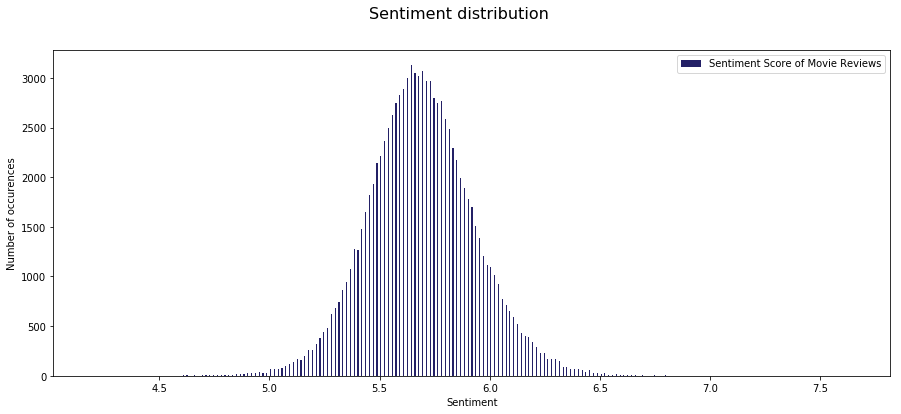

Average of average weighted happiness in review: 5.698057216744183
Standard deviation of average weighted happiness in review: 0.24207052989735794


In [7]:
Blue = "#232066"
nbins= 200
# Get the histograms
hist, bins = histogramCont(scores,nbins)
plt.figure(figsize = (15,6))
plt.bar(bins[:-1], hist, 1/nbins, color=Blue, label = "Sentiment Score of Movie Reviews") #0 exlcuded due to no sentiment
plt.xlabel('Sentiment')
plt.ylabel('Number of occurences')
plt.suptitle('Sentiment distribution', fontsize=16)
plt.legend()
plt.savefig("Figures/SentimentHistogram.svg")
plt.savefig("Figures/SentimentHistogram.jpeg")
plt.savefig("Figures/SentimentHistogram.png")
plt.savefig("Figures/SentimentHistogram.pdf")
plt.show()
print "Average of average weighted happiness in review: " + str(np.mean(scores))
print "Standard deviation of average weighted happiness in review: " + str(np.std(scores))

In [8]:
positiveReviews = []
negativeReviews = []
mu = np.mean(scores)
sig = np.std(scores)
for path in paths:
    done = len(os.listdir("aclImdb/"+path))
    for idx,filename in enumerate(os.listdir("aclImdb/"+path)):
        file = io.open("aclImdb/"+path+"/"+filename, mode="r", encoding="utf-8")
        string = file.readlines()[0]
        w = re.findall(r'@\w*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[\/\w+]*', string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        w = re.findall("<[^>]*>",string)
        for i in range(0, len(w)):
            string = string.replace(w[i], "")
        string = re.sub(r'\d+', '', string)
        string = string.lower()
        filtered = tokenizer.tokenize(string)
        filtered = [w for w in filtered if w not in stopwordslist]
        review = Counter(filtered)
        score = happiness(review,dict_to_compare)
        if score <=(mu-2*sig):
            negativeReviews=np.concatenate((negativeReviews,filtered))
        elif score>=(mu+2*sig):
            positiveReviews = np.concatenate((positiveReviews,filtered))
        if idx/done*100%10==0:
            print("Done with {0}% in the corresponding folder {1}.".format(idx/done*100,path))

Done with 0.0% in the corresponding folder train/unsup.
Done with 10.0% in the corresponding folder train/unsup.
Done with 20.0% in the corresponding folder train/unsup.
Done with 30.0% in the corresponding folder train/unsup.
Done with 40.0% in the corresponding folder train/unsup.
Done with 50.0% in the corresponding folder train/unsup.
Done with 60.0% in the corresponding folder train/unsup.
Done with 70.0% in the corresponding folder train/unsup.
Done with 80.0% in the corresponding folder train/unsup.
Done with 90.0% in the corresponding folder train/unsup.
Done with 0.0% in the corresponding folder train/pos.
Done with 10.0% in the corresponding folder train/pos.
Done with 20.0% in the corresponding folder train/pos.
Done with 30.0% in the corresponding folder train/pos.
Done with 40.0% in the corresponding folder train/pos.
Done with 50.0% in the corresponding folder train/pos.
Done with 60.0% in the corresponding folder train/pos.
Done with 70.0% in the corresponding folder tra

In [10]:
def TFIDF(doc, docs_to_compare):
    #Doc is the document (dict with count as value) for which TDIDF is caluclated
    #docs_to_compare is a list of documents (same format as above) to be compared with
    length = float(sum(doc.values()))
    #Dual comprehension for speedup (casted to C)
    return Counter({key: float(value)/length*math.log(float(len(docs_to_compare)+1)/float(1+sum(1 for docs in docs_to_compare if key in docs.keys()))) for key,value in doc.items()})

In [11]:
NegativeCounter = Counter(negativeReviews)
PositiveCounter = Counter(positiveReviews)
NegativeTFIDF = TFIDF(NegativeCounter,[PositiveCounter])
PositiveTFIDF = TFIDF(PositiveCounter, [NegativeCounter])

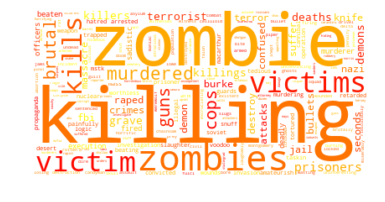

In [32]:
wordcloud = WordCloud(background_color='white',colormap = "autumn")
wordcloud.generate_from_frequencies(frequencies=NegativeTFIDF)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("Figures/NegativeCloud.svg")
plt.savefig("Figures/NegativeCloud.jpeg")
plt.savefig("Figures/NegativeCloud.png")
plt.savefig("Figures/NegativeCloud.pdf")
plt.show()

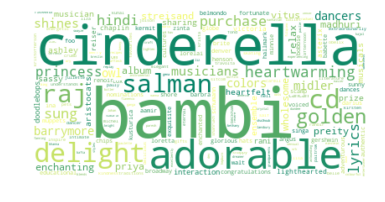

In [25]:
wordcloud = WordCloud(background_color='white', colormap="summer")
wordcloud.generate_from_frequencies(frequencies=PositiveTFIDF)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()